In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_columns', 30)

### Data

In [2]:
df1 = pd.read_csv('../DATA/clean-HSC-unWISE-W01.csv')
df1 = df1.drop(columns = [f for f in df1.columns if ('isnull' in f)])
df2 = pd.read_csv('../DATA/clean-HSC-unWISE-W02.csv')
df2 = df2.drop(columns = [f for f in df2.columns if ('isnull' in f)])
df = pd.concat([df1,df2], axis = 'rows')
del df1,df2

df['gr'] = df['g_cmodel_mag'] - df['r_cmodel_mag']
df['ri'] = df['r_cmodel_mag'] - df['i_cmodel_mag']
df['iz'] = df['i_cmodel_mag'] - df['z_cmodel_mag']
df['zy'] = df['z_cmodel_mag'] - df['y_cmodel_mag']

with open('../DATA/features1.txt') as file:
    features = file.read().splitlines()
labels = 'member'

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 40238 (16.58%)
Non members: 202457 (83.42%)


In [4]:
# Undersample majority class
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy= 4./6., replacement= False)
rus_feat, rus_lab = rus.fit_resample(df[features], df[labels])
rus_feat[labels] = rus_lab

df = rus_feat
del rus, rus_feat, rus_lab

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 40238 (40.00%)
Non members: 60357 (60.00%)


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.35, stratify = df[labels])
print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0]))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Training: 26154 members, 39232 non members
Testing: 14084 members, 21125 non members


### Model & Searches

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap= True, n_jobs = -1, verbose= 0, class_weight= 'balanced')

params = dict(
    n_estimators = [20,50,80,100,120],
    criterion = ['gini', 'entropy', 'log_loss'],
    max_depth = [None, 10, 20, 30],
    min_samples_split = [2, 5, 10, 15],
    min_samples_leaf = [1, 2, 4, 10],
    max_features = ['sqrt', 'log2', None]
    # max_leaf_nodes = [None, 50, 20],
    # min_impurity_decrease = [0.0, 0.1, 0.01, 0.001, 0.0001],
    # max_samples = [None, 0.5, 0.25, 0.75]
)

from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(estimator= model, param_distributions= params, cv= 3, n_jobs= -1,  verbose= 4, n_iter = 100)
rs.fit(df[features], df[labels])

df_rs = pd.DataFrame(rs.cv_results_)

In [6]:
# make a new model with best parameters...
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap= True, n_jobs = -1, verbose= 0, class_weight= 'balanced',
                               n_estimators= 120, min_samples_leaf= 2, min_samples_split= 2,  max_features= 'log2', max_depth= 10, criterion= 'entropy')

model.fit(df[features], df[labels])

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=2,
                       n_estimators=120, n_jobs=-1)

### Tests


In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

pred = model.predict(test[features])
scores = model.predict_proba(test[features])
model_score = model.score(test[features], test[labels])

fpr, tpr, thresholds_roc = roc_curve(test[labels], scores[:,1], pos_label=1)
precision, recall, thresholds_pr = precision_recall_curve(test[labels], scores[:,1], pos_label= 1)

print(f'Model score: {model_score}')
print('ROC AUC: {}'.format(auc(fpr, tpr)))
print('Precision-recall AUC: {}'.format(auc(recall, precision)))
print('-'*70)
print(classification_report(test[labels],pred))

Model score: 0.6903916612229828
ROC AUC: 0.7703773101038738
Precision-recall AUC: 0.6672308134467744
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72     21125
           1       0.59      0.72      0.65     14084

    accuracy                           0.69     35209
   macro avg       0.69      0.70      0.69     35209
weighted avg       0.71      0.69      0.69     35209



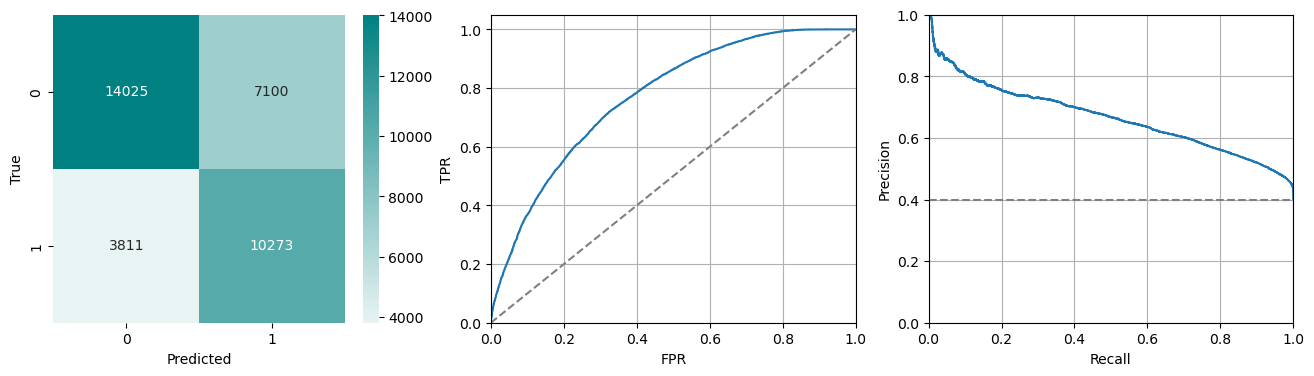

In [27]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,4))

# Confusion matrix
plt.subplot(1, 3, 1)
conf_m = confusion_matrix(test[labels], pred)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Precision-recall curve
plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()

<AxesSubplot: >

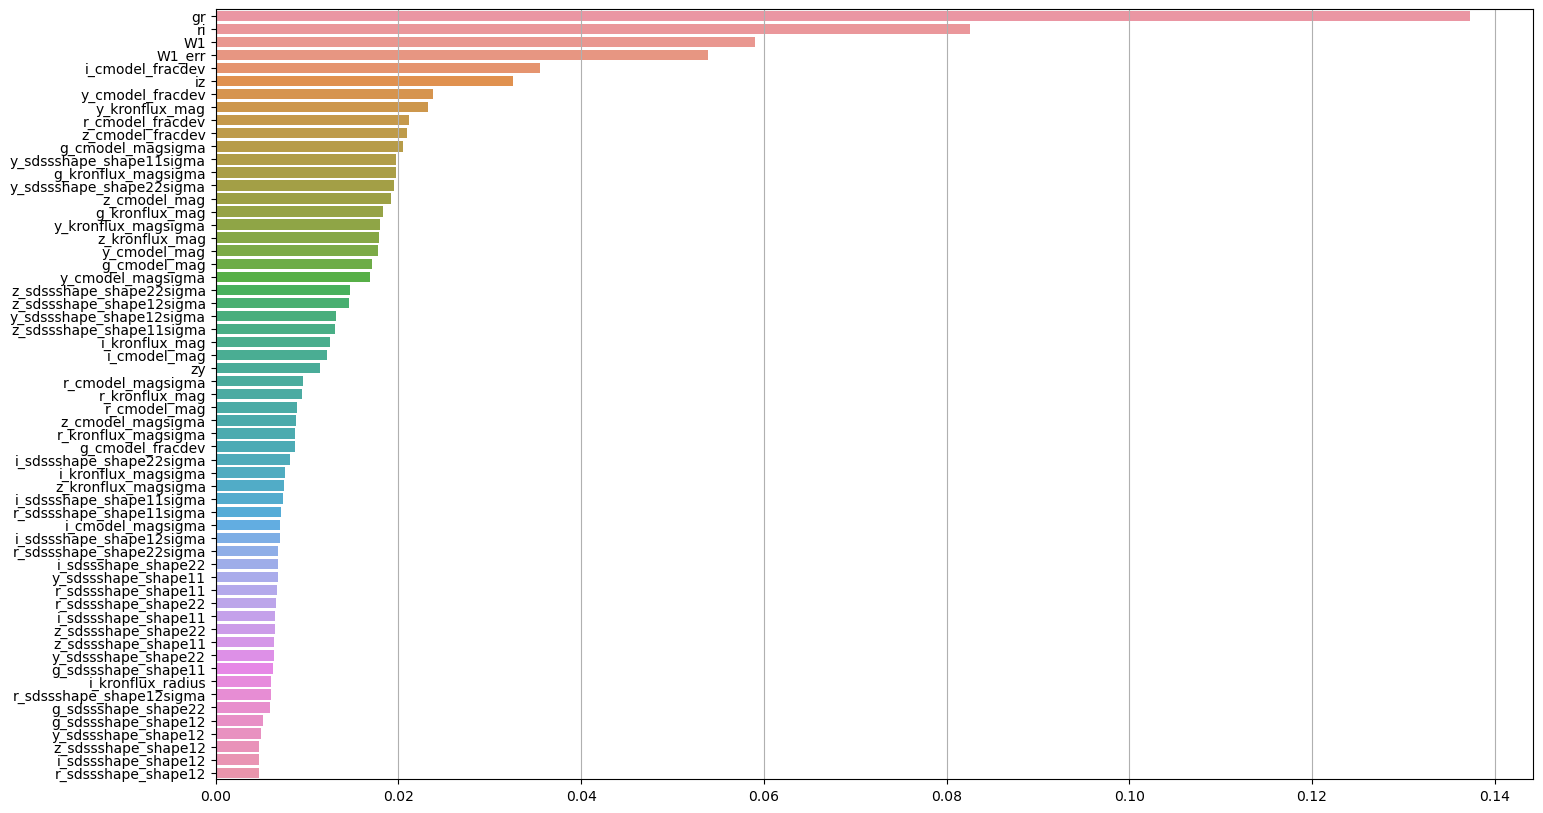

In [41]:
importances = np.sort(model.feature_importances_)[::-1]
sorted_features = [x for _,x in sorted(zip(model.feature_importances_, features))][::-1]

plt.figure(figsize= (17, 10))
plt.grid()
sns.barplot(x = importances, y = sorted_features)